In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install pyldavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=1e51efcad2189f7feec7a4677003af0d0121c4e859fa2589c71ac5a2930c89d4
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=bf5b531f187a779999c2a1b43ed9dc2975c1ecc09937afb0bfb334fb46baae75
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyldavis sklearn


In [22]:
from __future__ import print_function
import pandas as pd
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

filename = "AMAZON_FASHION_5.json"
#filename = "/content/drive/MyDrive/Github/CSCI-5525-final-project/AMAZON_FASHION_5.json"

df = pd.read_json(path_or_buf=filename, lines=True)




[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [1]:
df['asin'].value_counts()

In [2]:
list(df[df['asin'] == 'B009MA34NY']['reviewText'])

In [10]:
import json

#filename = "/content/drive/MyDrive/Github/CSCI-5525-final-project/AMAZON_FASHION_5.json"
with open(filename) as f:
    reviews_json = f.readlines()

reviews = []
for review_json in reviews_json:
    review = json.loads(review_json)
    if "overall" in review and "reviewText" in review:
        reviews.append(
            {
                "rating": review["overall"],
                "title": review["summary"],
                "text": review["reviewText"],
            }
        )

#df = pd.DataFrame.from_dict(reviews)

In [11]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# NMF and LDA
Adapted from [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html), minimal original work.

The topics are extracting nothing of note.

Further steps:

- find a product with enough reviews to be worth analyzing alone (might have to request the full dataset)
- mess around with heuristics for vectorizing terms (reducing `max_df` probably but didn't manage to get different results)
- eliminate boring reviews?

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
#from sklearn.decomposition import LatentDirichletAllocation

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

product_id = 'B009MA34NY'
if product_id:
    data_samples = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
else:
    data_samples = list(map(lambda x: x['text'], reviews))[:n_samples]


for s in data_samples:

    if not isinstance(s,str):
        print(s)

In [14]:
#preprocessing
def lowercasing(data_samples):
  for idx, sample in enumerate(data_samples):
    data_samples[idx] = sample.lower()
  return data_samples

def punctuation_removal(data_samples):
#non-exhaustive; not sure if we want to treat punctuation as significant
#doesn't remove punctuation from inside words
  for i, sample in enumerate(data_samples):
    _sample = sample.split()
    for j, word in enumerate(_sample):
      _sample[j] = word.strip(" .!?@#&():;,'\/\\")
    sample = " ".join(_sample)
    data_samples[i] = sample
  return data_samples

#credit to Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(data_samples):
  wnl = WordNetLemmatizer()
  for i, sample in enumerate(data_samples):
      _sample = sample.split()
      for j, word in enumerate(_sample):
        tag = get_wordnet_pos(word)
        _sample[j] = wnl.lemmatize(word,tag)
      data_samples[i] = " ".join(_sample)
  return data_samples

data_samples = lowercasing(data_samples)
data_samples = punctuation_removal(data_samples)
data_samples = lemmatize(data_samples)

<>:13: DeprecationWarning: invalid escape sequence \/
<>:13: DeprecationWarning: invalid escape sequence \/
<>:13: DeprecationWarning: invalid escape sequence \/
<ipython-input-14-92544d6dc7ce>:13: DeprecationWarning: invalid escape sequence \/
  _sample[j] = word.strip(" .!?@#&():;,'\/\\")


In [15]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.03, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print(tfidf.shape)

Extracting tf-idf features for NMF...
(375, 343)


In [ ]:
len(data_samples)

375

In [ ]:
print(len(tfidf_vectorizer.stop_words_))
tfidf_vectorizer.stop_words_

563


{'000',
 '100',
 '12',
 '15',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '30',
 '3rd',
 '3x',
 '40',
 '50',
 'abd',
 'abit',
 'absolutly',
 'absorption',
 'accommodate',
 'accurately',
 'achilles',
 'adjust',
 'adjustment',
 'advice',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'amazing',
 'anymore',
 'apart',
 'arch',
 'arose',
 'artculo',
 'asics',
 'attention',
 'az',
 'bag',
 'bailing',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'barely',
 'beach',
 'beat',
 'bed',
 'believe',
 'bend',
 'big',
 'blood',
 'bluff',
 'bootcamps',
 'bought',
 'boxier',
 'breath',
 'breathe',
 'breathes',
 'broader',
 'btw',
 'build',
 'bulk',
 'bunion',
 'business',
 'buy',
 'cable',
 'calf',
 'cam',
 'card',
 'care',
 'careful',
 'carpet',
 'carpeted',
 'certain',
 'certainly',
 'cheap',
 'check',
 'chic',
 'christmas',
 'circulation',
 'cl',
 'class',
 'cleaning',
 'client',
 'clorox',
 'close',
 'closer',
 'closet',
 'clothes',
 'coach',
 'color',
 'colors',
 'colour',
 'come'

In [ ]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)


Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


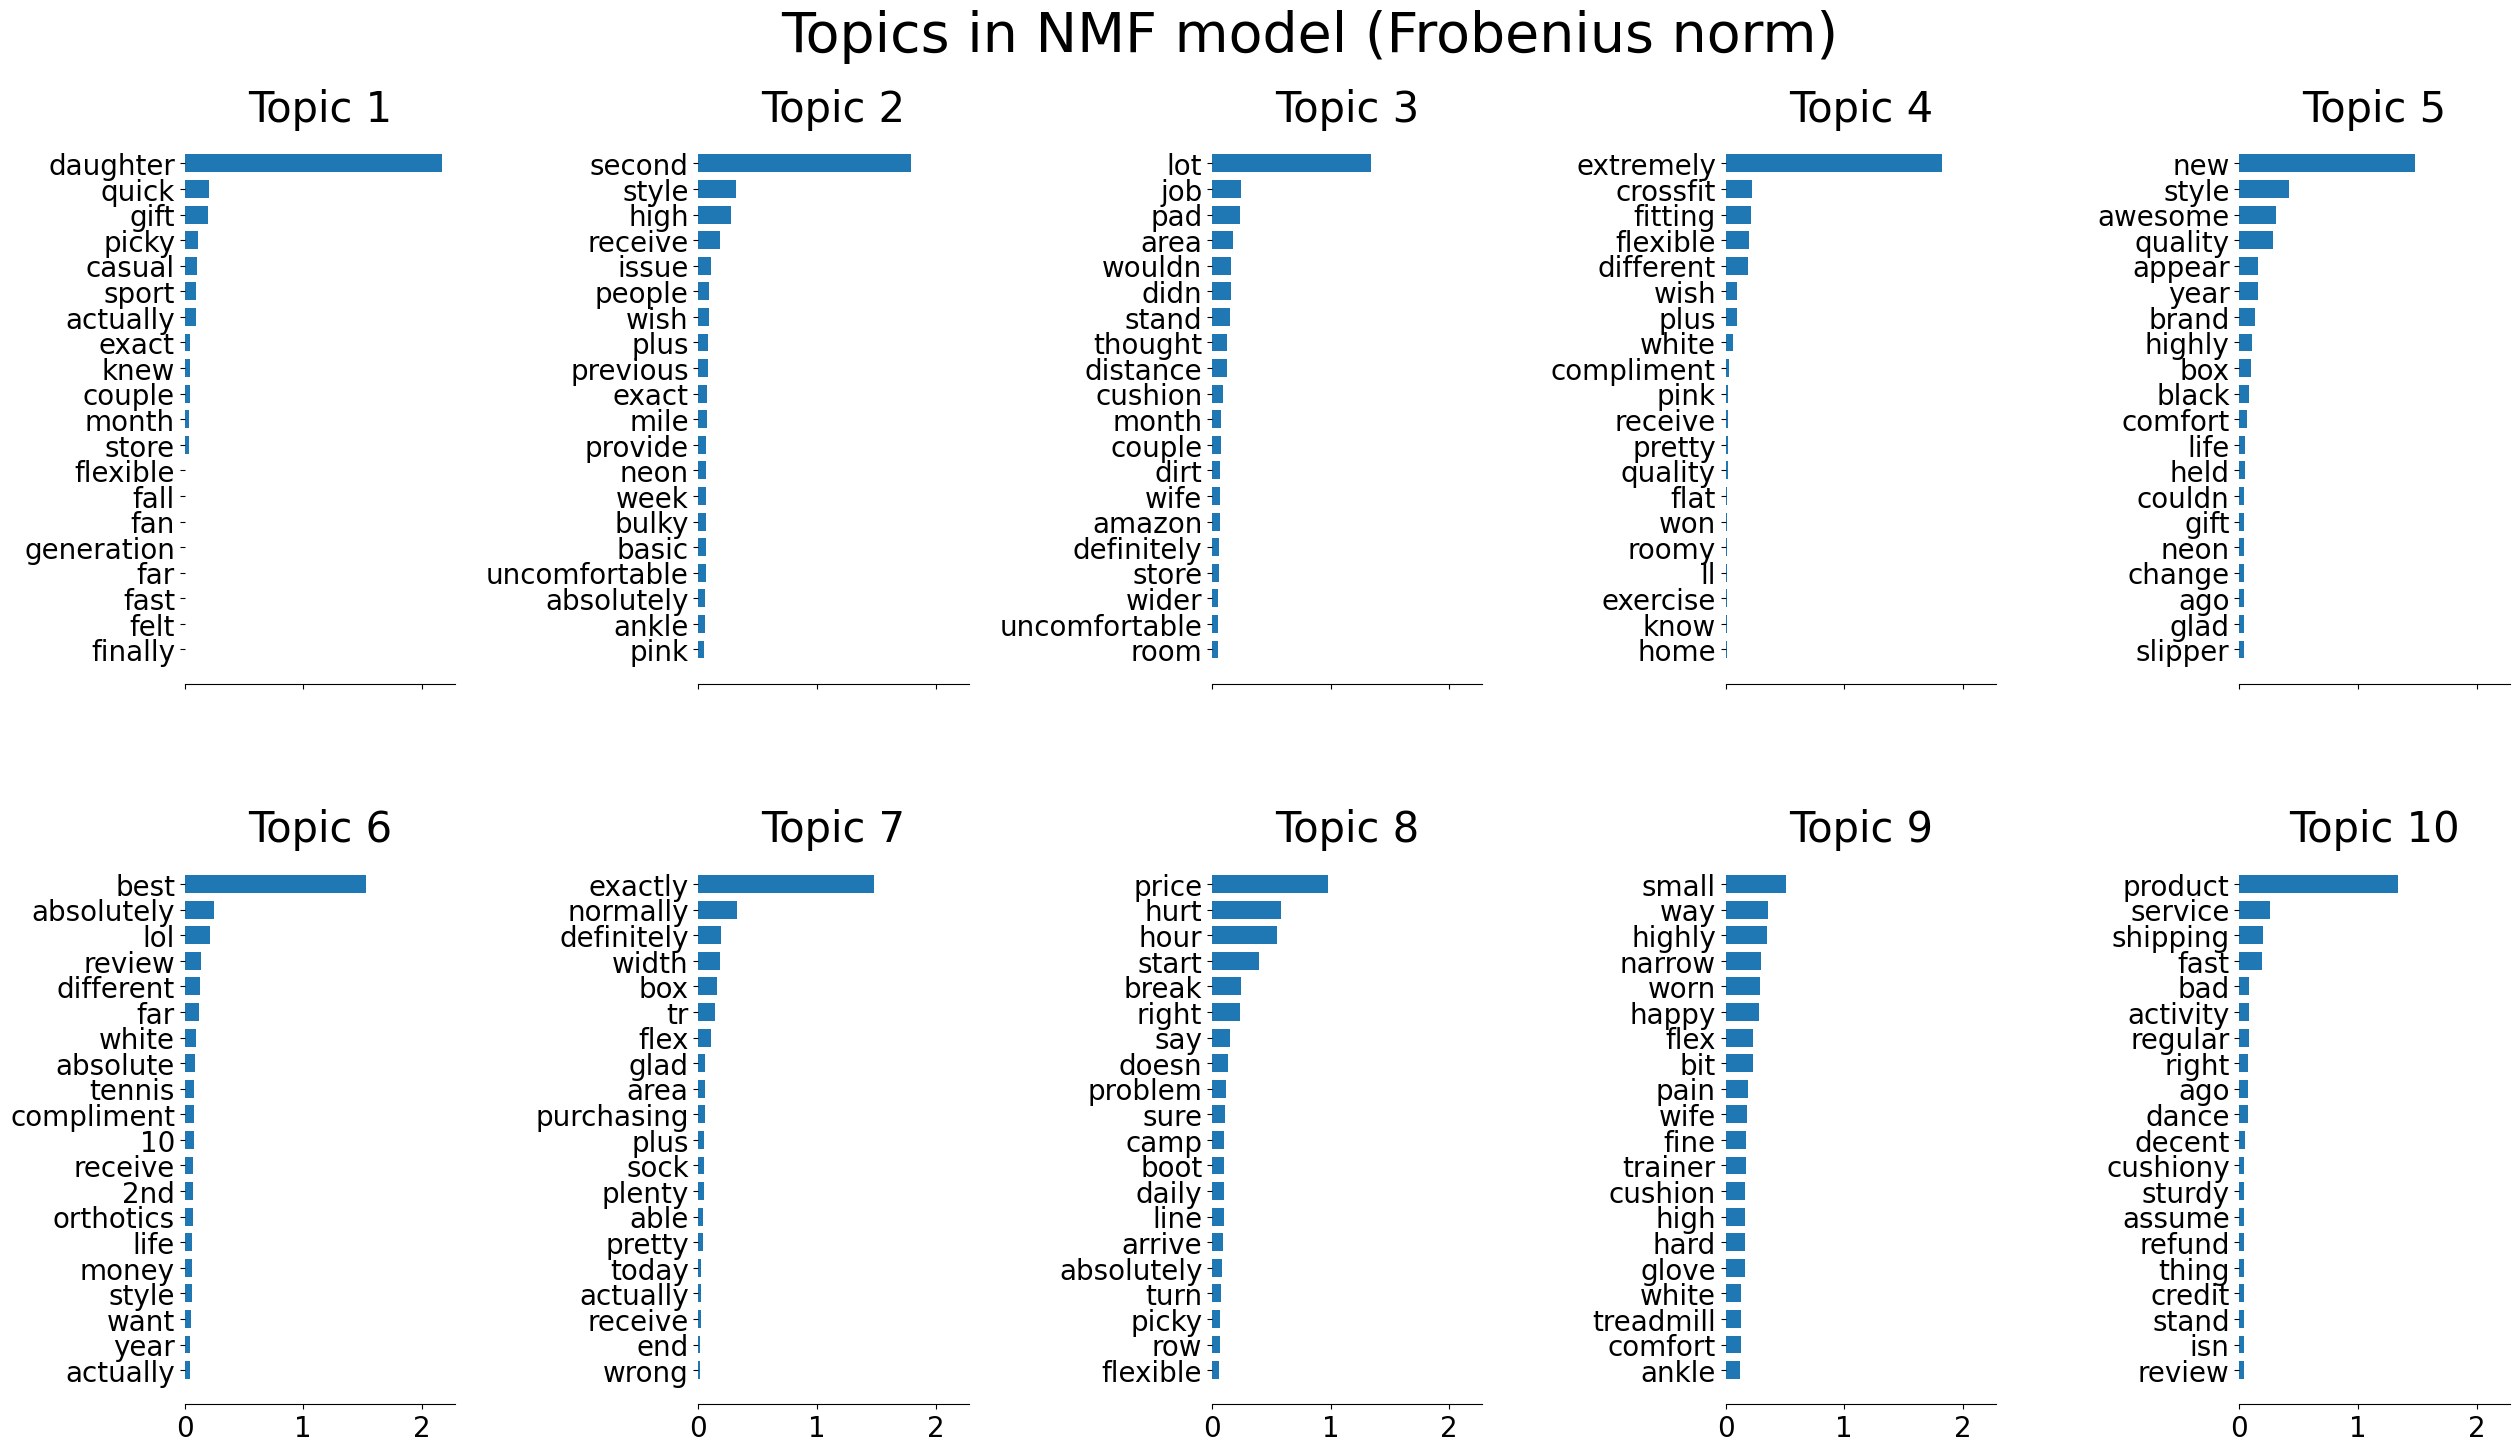

In [ ]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, 
    tfidf_feature_names, 
    n_top_words, 
    "Topics in NMF model (Frobenius norm)"
)

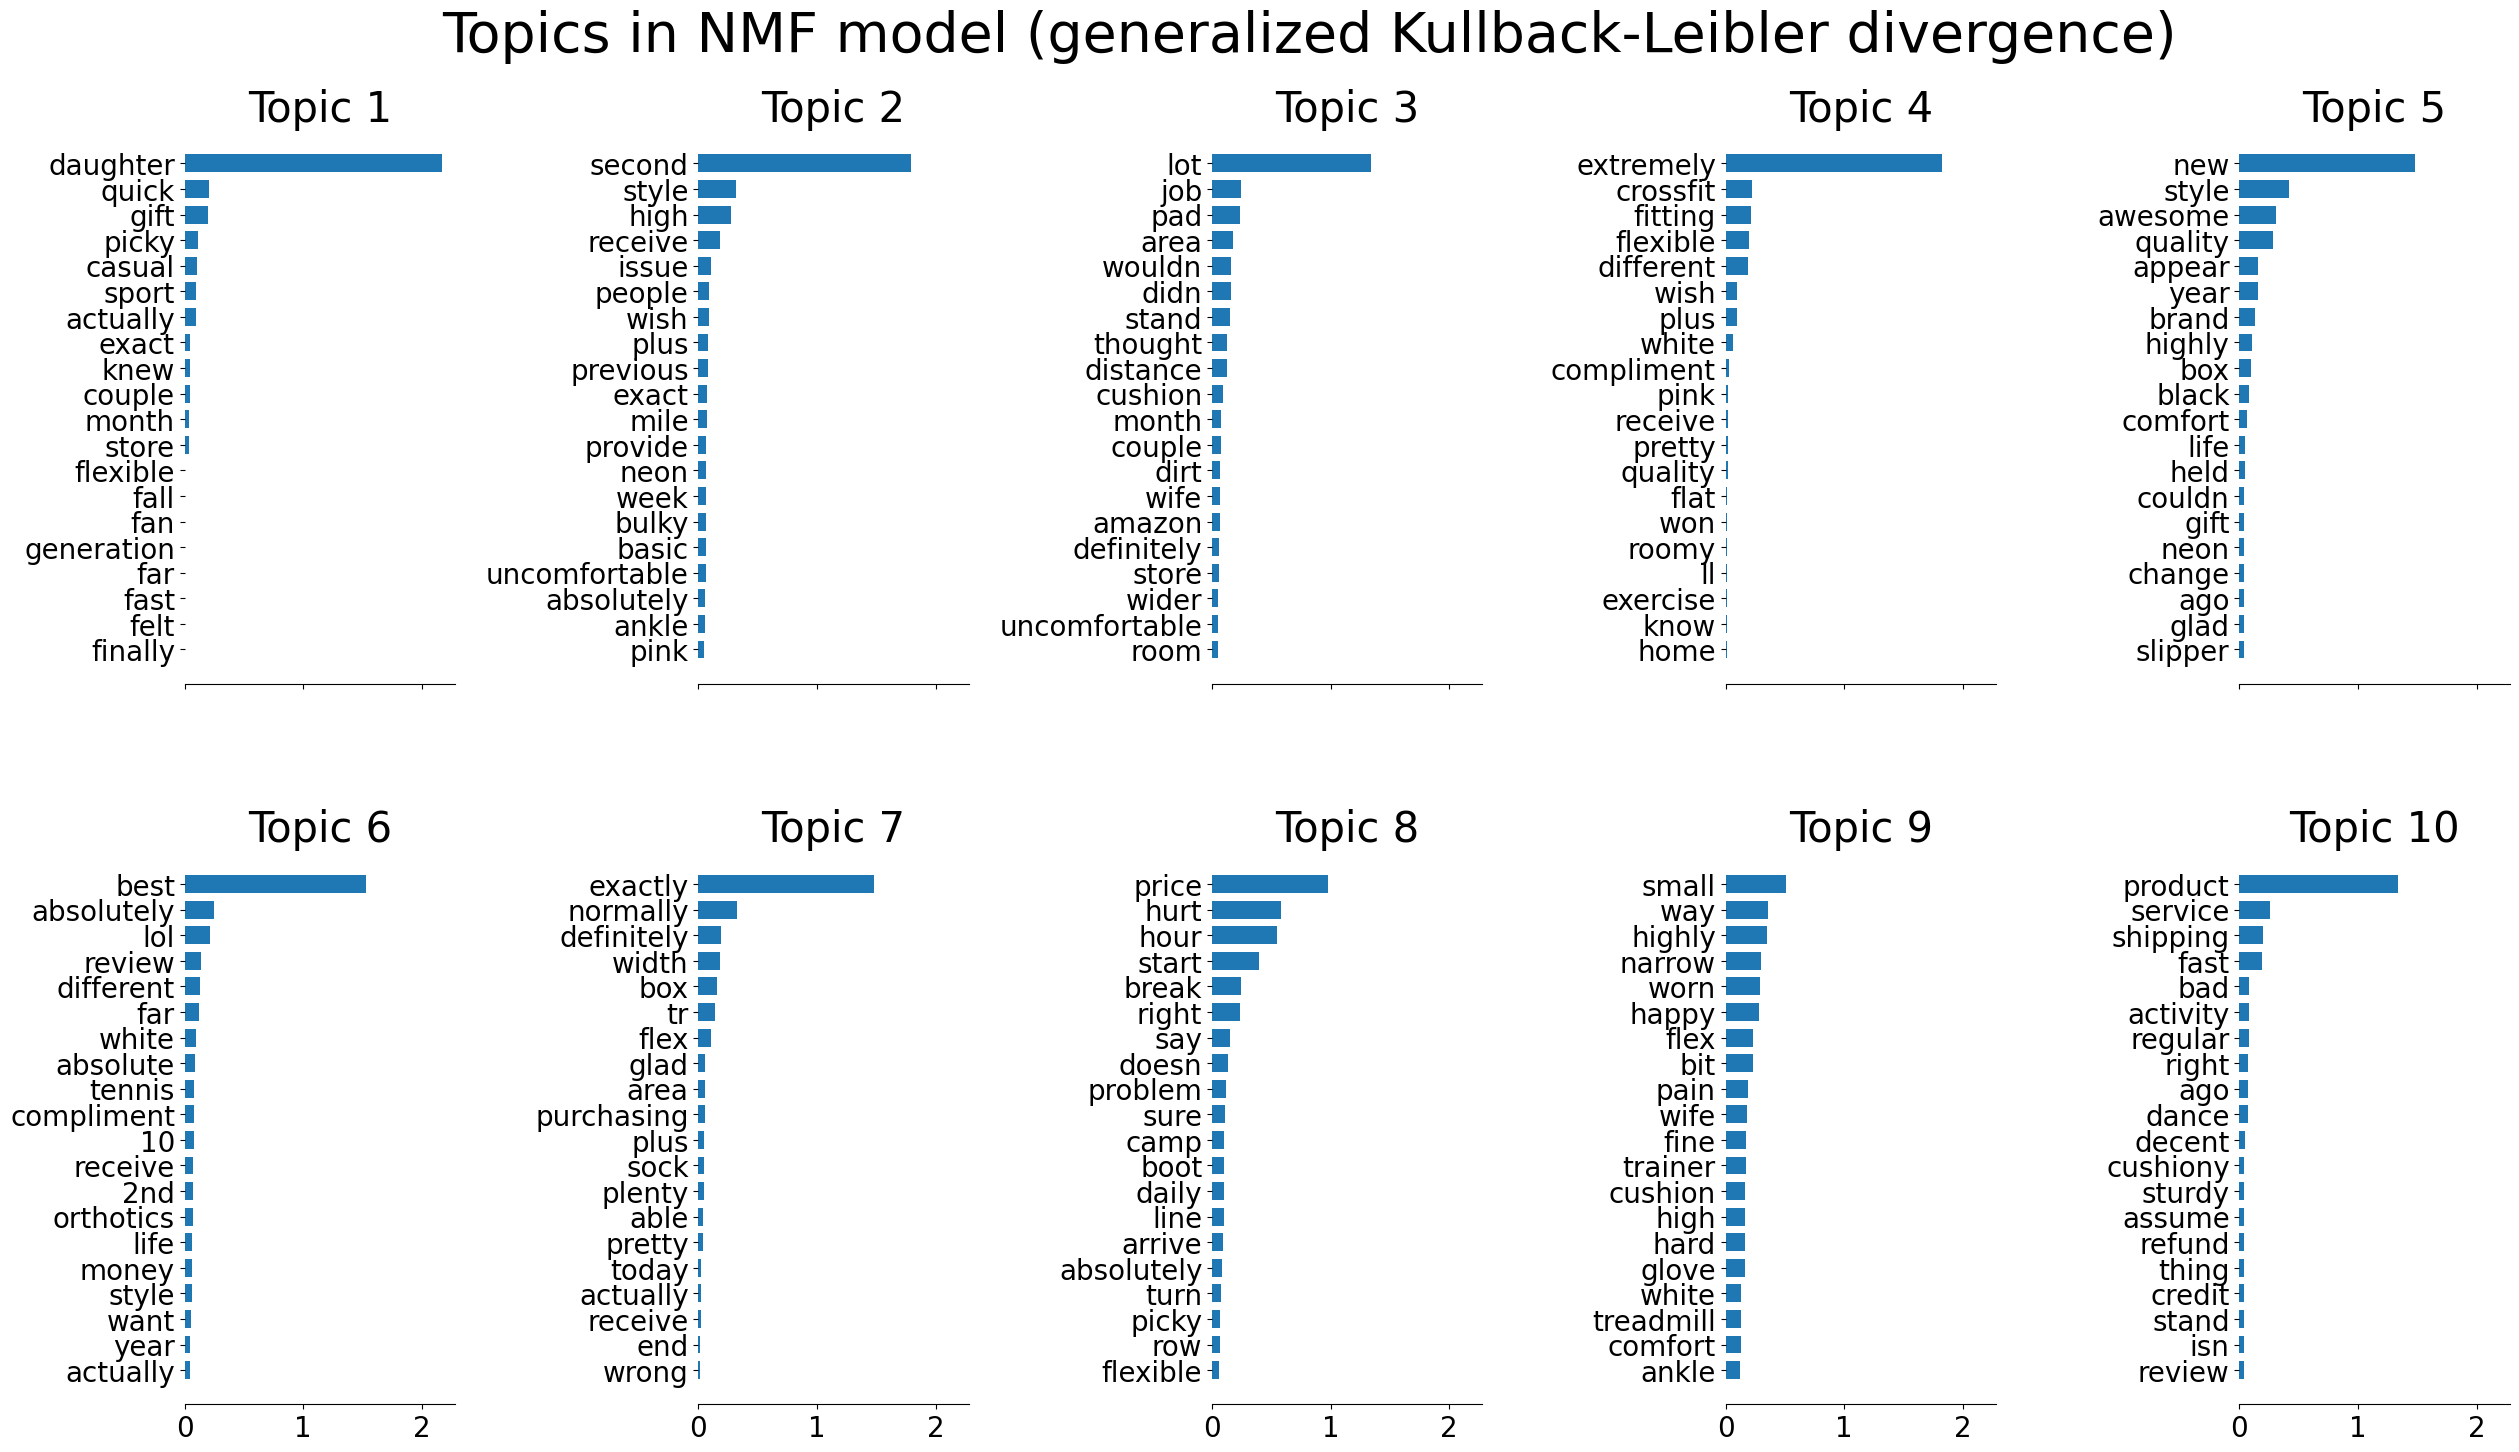

In [ ]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

In [ ]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


/Users/shy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:2308: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


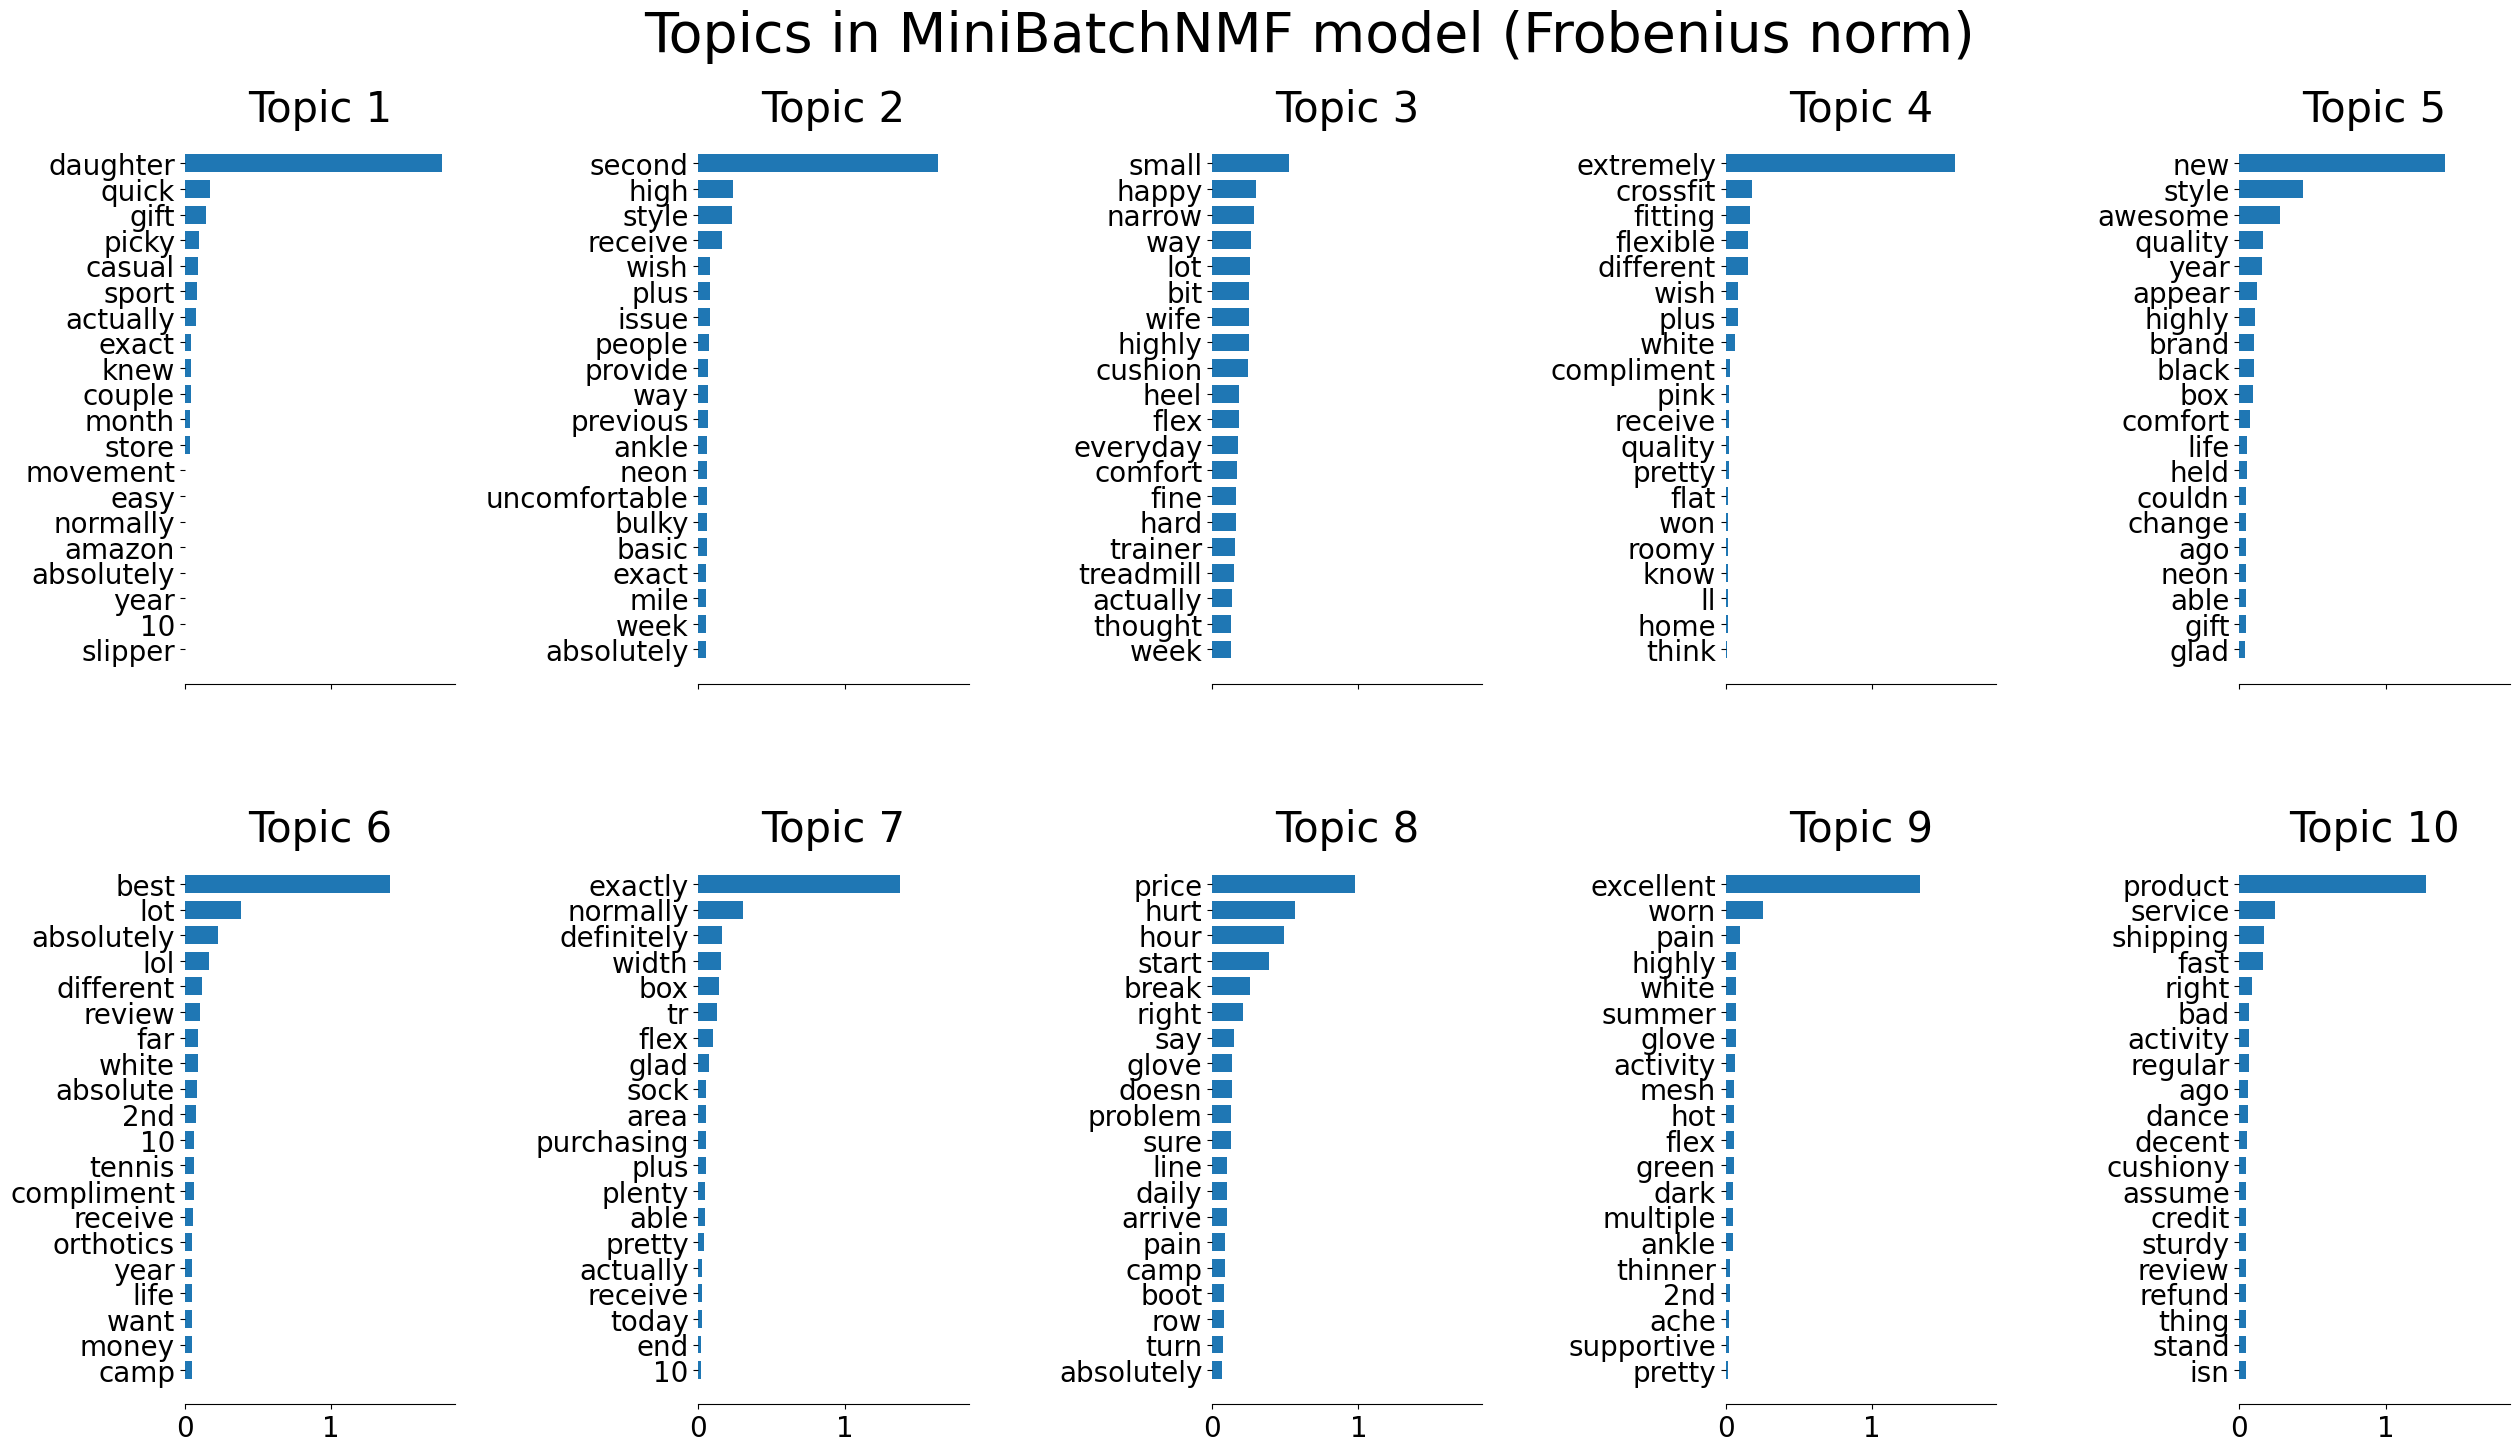

In [ ]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

In [ ]:
# Fit the MiniBatchNMF model
print(
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


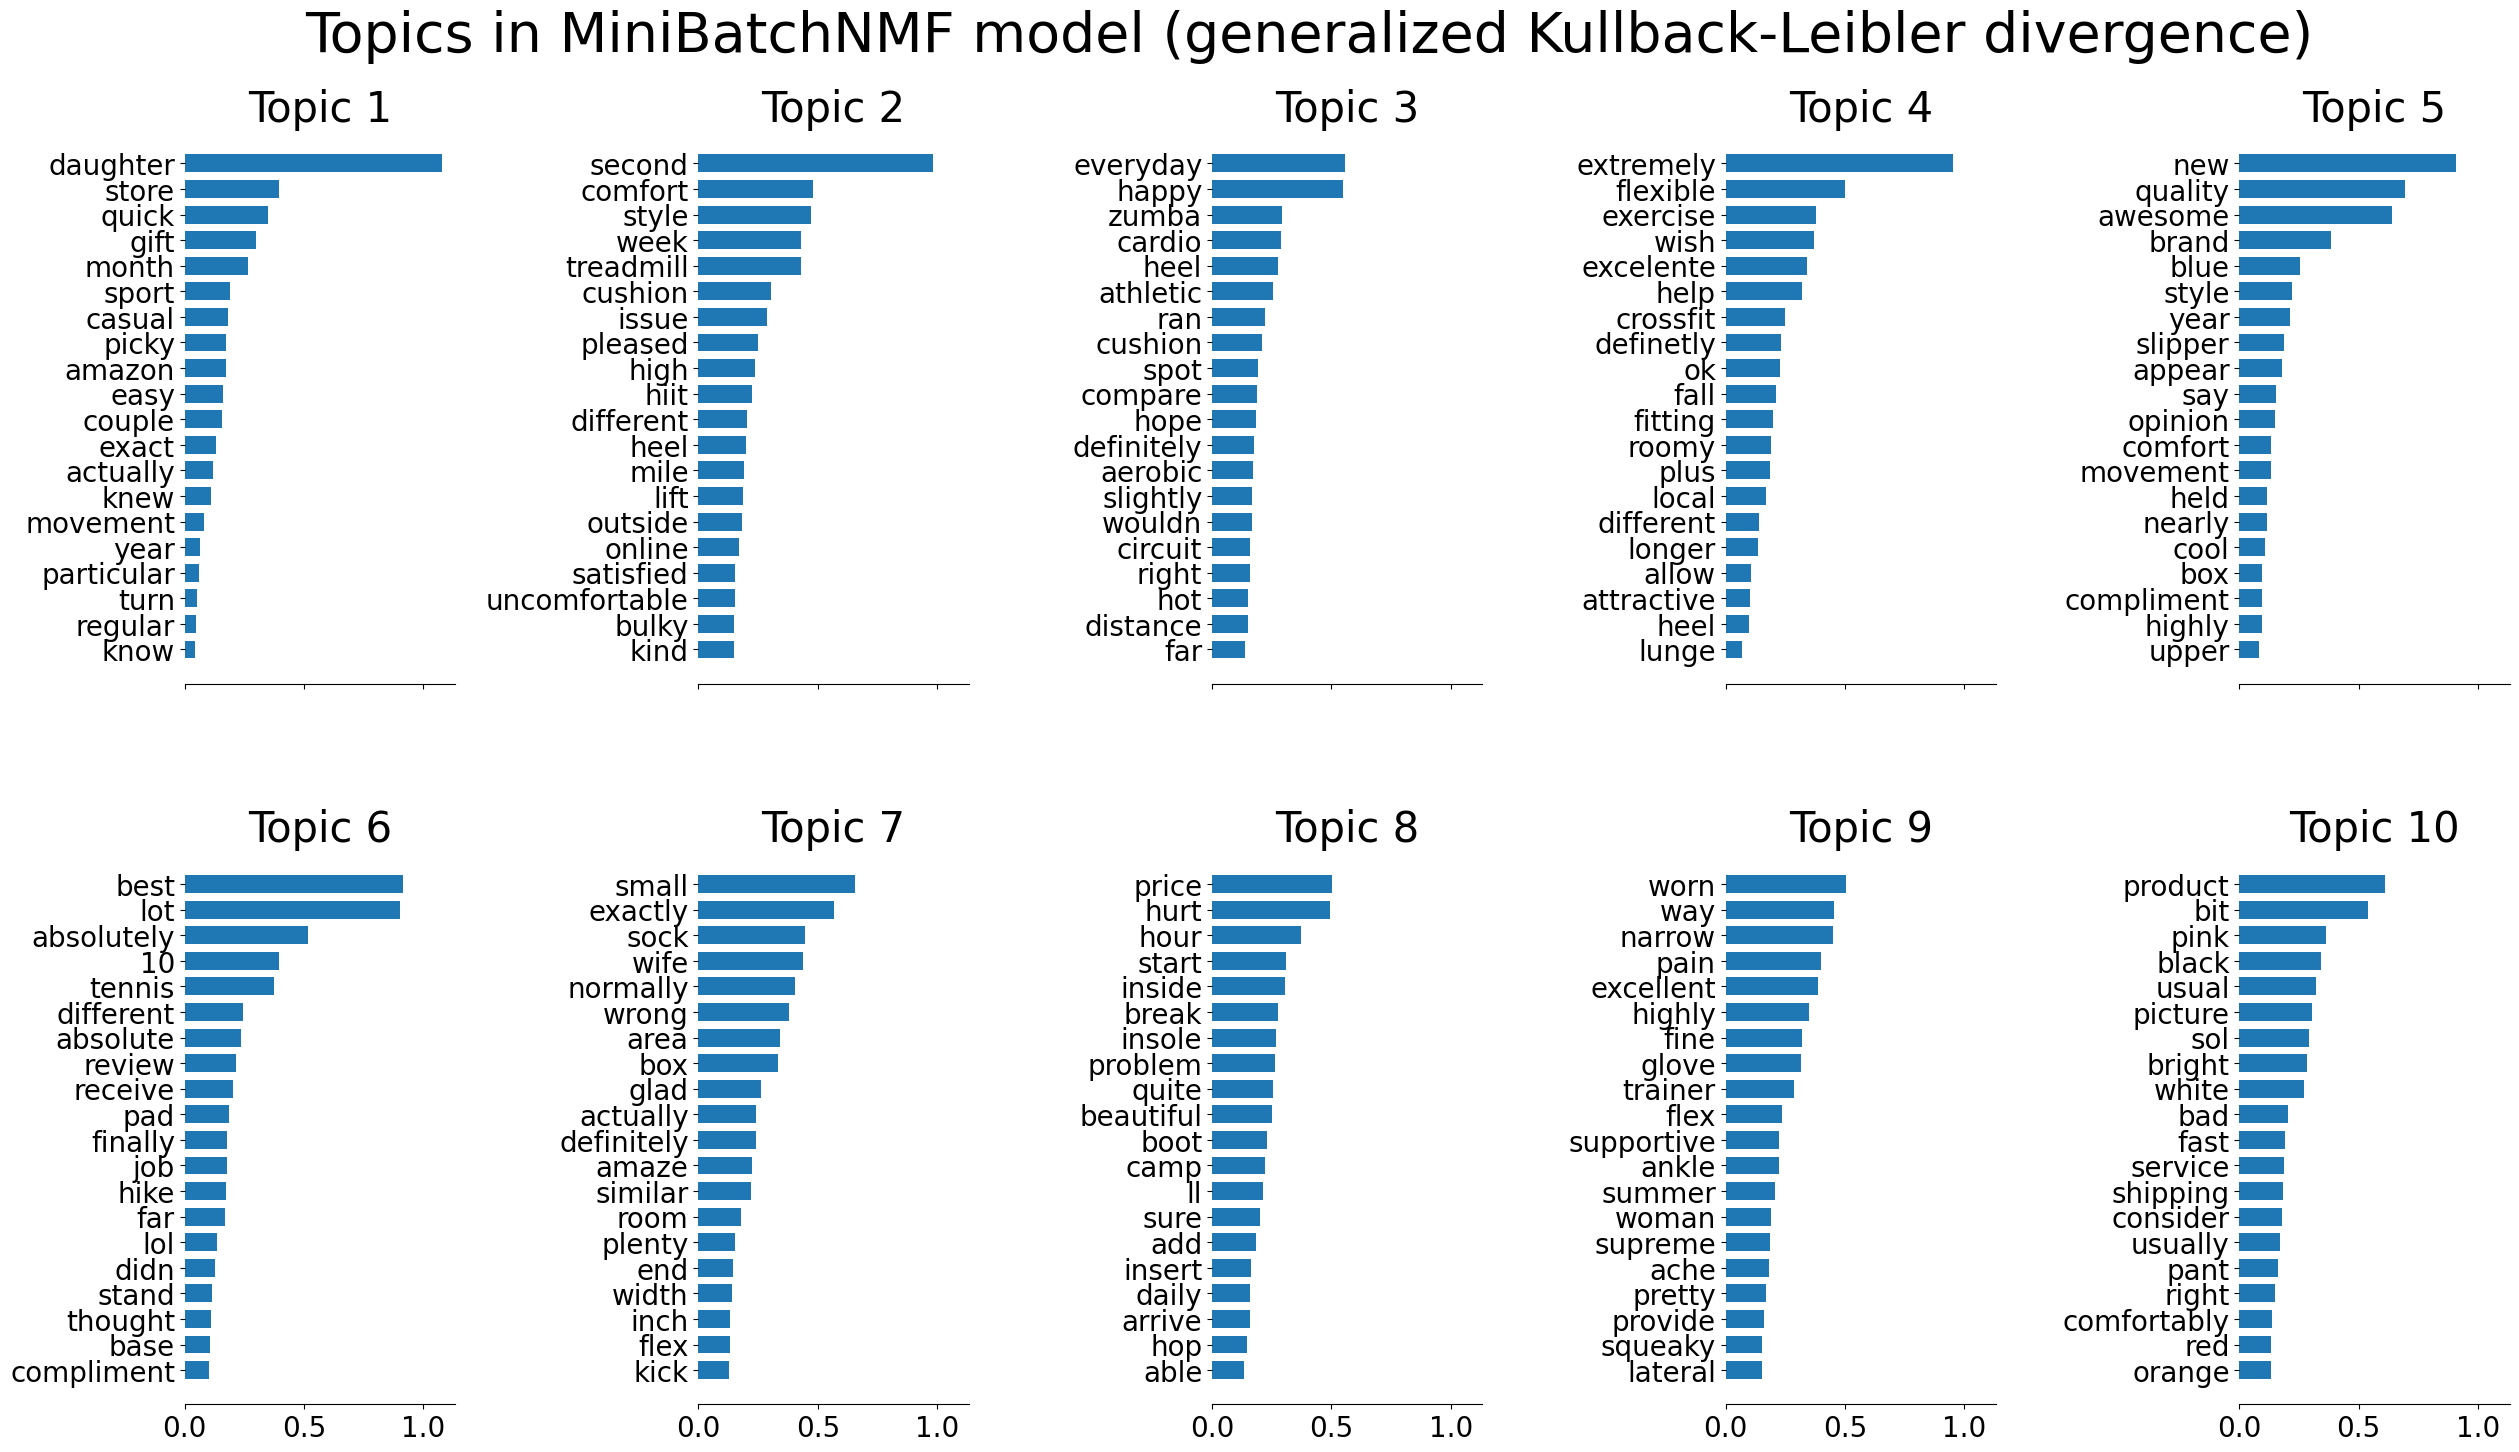

In [ ]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

In [16]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.01, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_samples)
tf_vectorizer.stop_words_

Extracting tf features for LDA...


{'000',
 '10',
 '100',
 '12',
 '15',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '30',
 '3rd',
 '3x',
 '40',
 '50',
 'abd',
 'abit',
 'able',
 'absolutely',
 'absolutly',
 'absorption',
 'accommodate',
 'accurately',
 'ache',
 'achilles',
 'activity',
 'actually',
 'adjust',
 'adjustment',
 'advice',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'amazing',
 'amazon',
 'ankle',
 'anymore',
 'apart',
 'arch',
 'area',
 'arose',
 'arrive',
 'artculo',
 'asics',
 'athletic',
 'attention',
 'away',
 'awesome',
 'az',
 'bag',
 'bailing',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'barely',
 'beach',
 'beat',
 'bed',
 'believe',
 'bend',
 'best',
 'big',
 'bit',
 'black',
 'blister',
 'blood',
 'bluff',
 'boot',
 'bootcamps',
 'bought',
 'box',
 'boxier',
 'brand',
 'break',
 'breath',
 'breathe',
 'breathes',
 'bright',
 'broader',
 'btw',
 'build',
 'bulk',
 'bunion',
 'business',
 'buy',
 'cable',
 'calf',
 'cam',
 'card',
 'cardio',
 'care',
 'careful',
 'carpet',
 'ca

Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


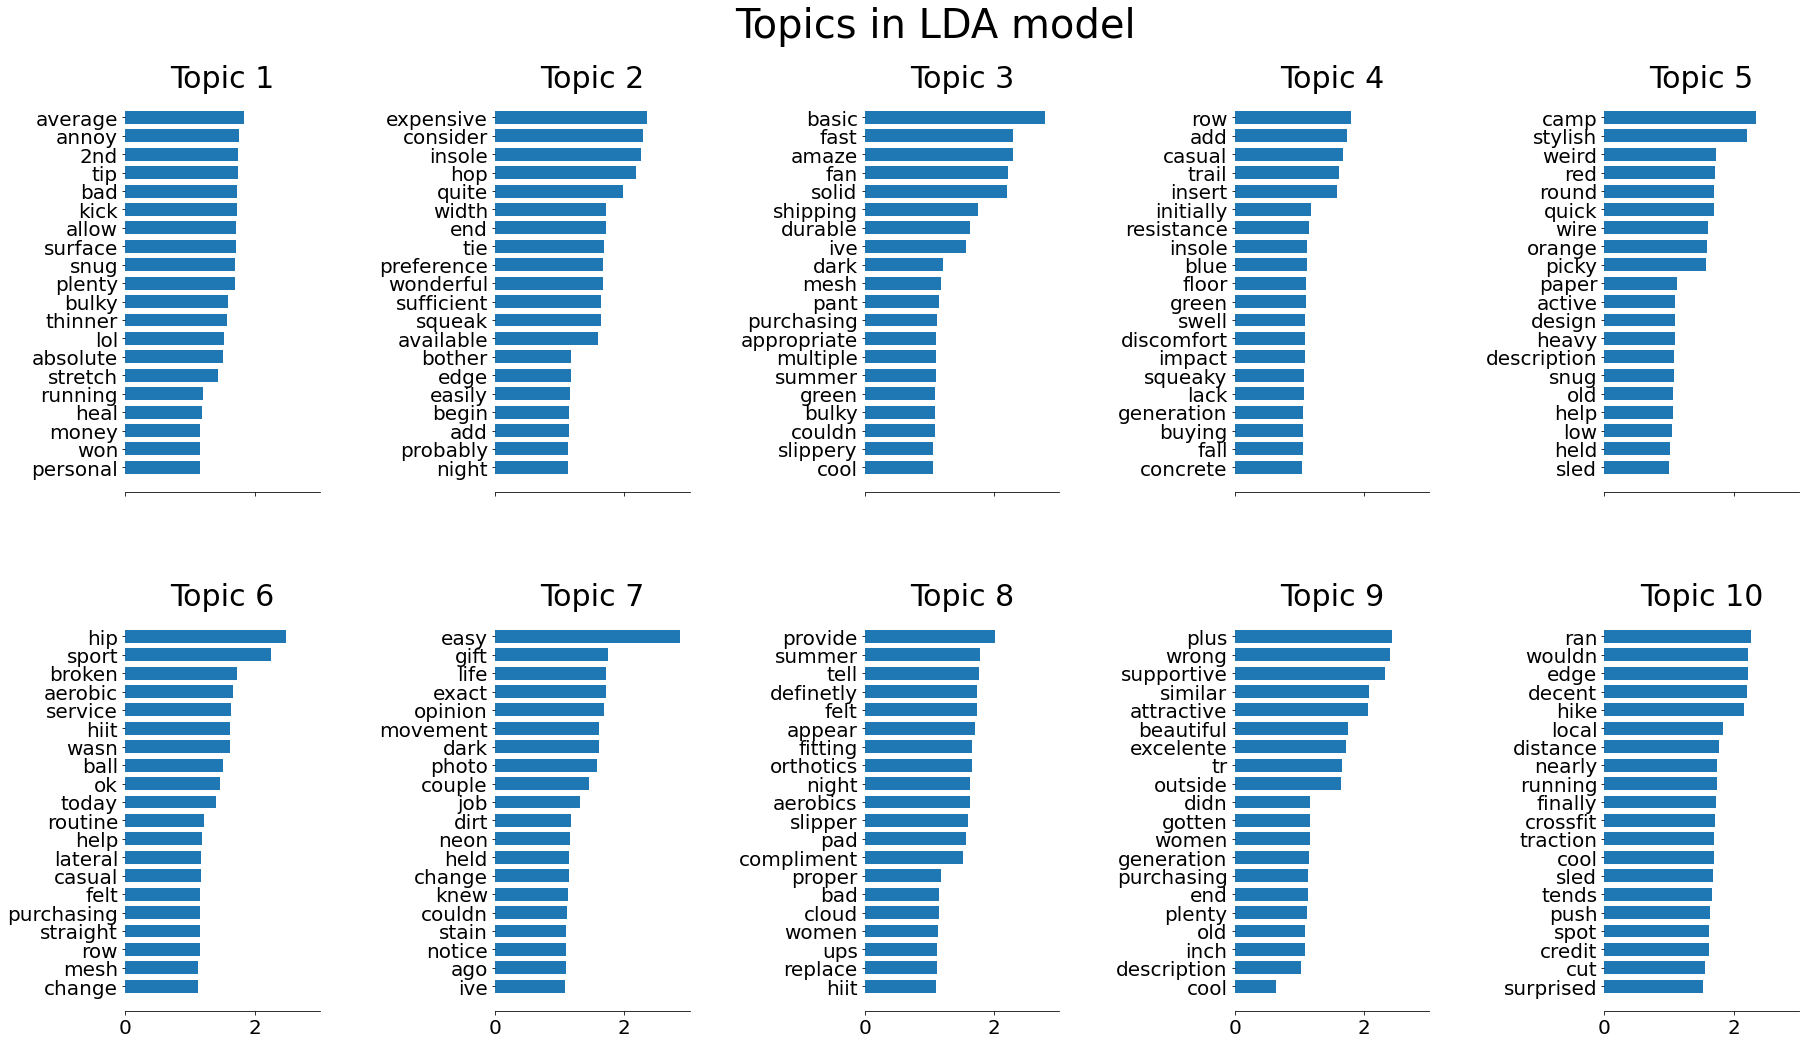

In [19]:
print(
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [23]:
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.046713  0.021535       1        1  16.348239
1      0.034238  0.025541       2        1  14.019571
0     -0.003580 -0.031583       3        1  11.338804
5      0.011935  0.002708       4        1  10.519912
6      0.000850 -0.011312       5        1  10.078595
2     -0.002441 -0.002596       6        1   8.882116
7     -0.001763 -0.001338       7        1   8.684419
3      0.002748  0.005290       8        1   7.290193
4     -0.001531 -0.003086       9        1   6.578902
8      0.006256 -0.005158      10        1   6.259249, topic_info=           Term      Freq     Total Category  logprob  loglift
139        plus  2.000000  2.000000  Default  30.0000  30.0000
211       wrong  2.000000  2.000000  Default  29.0000  29.0000
21        basic  2.000000  2.000000  Default  28.0000  28.0000
183  supportive  2.000000  2.000000  Default  27.0000  27.0000
32         camp  2.000000  2.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
181  sufficient  0.146516  2.401344  Topic10  -5.3859  -0.0255
110         low  0.139601  2.318303  Topic10  -5.4342  -0.0387
43       couldn  0.152738  2.702495  Topic10  -5.3443  -0.1021
117      nearly  0.146315  2.517969  Topic10  -5.3873  -0.0743
164        sled  0.144868  2.538591  Topic10  -5.3972  -0.0924

[369 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         3  0.427189        2nd
1         3  0.426644   absolute
4         2  0.401346        add
4         8  0.401346        add
5         4  0.422787    aerobic
...     ...       ...        ...
205       2  0.373088      width
208       2  0.412596        won
209       2  0.411803  wonderful
210       1  0.363297     wouldn
211      10  0.431542      wrong

[177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 1, 6, 7, 3, 8, 4, 5, 9])

In [ ]:
for i, sample in enumerate(data_samples):
    if len(sample) > 300 and len(sample) < 700:
        print(i,":", sample)

4 : try them on in a store before buying online so i knew they'd fit good overall i be look for a durable cross training shoe that would hold up to my rigorous training and these have be great so far they be really light and comfortable most importantly for me they have grip on the bottom so my foot don't slide out from under me while do plank push-ups etc highly satisfied with this purchase
60 : glad i read the review and order a half size too big these be light weight i work out in them last night and have a great work out they be very comfortable i would recommend these to anyone i be a beach body coach and these be now my new favorite shoe to work out in i feel like i be walk in slipper when i wear these shoe they be so comfortable i love them so much i never buy myself anything nice and for christmas get an amazon gift card and use it to buy myself these sneaker and they be so awesome i really do love them and have be tell all my friend about them get these shoe
62 : i love these 

In [ ]:
lda.transform(tf_vectorizer.transform([data_samples[13]]))

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])

In [ ]:
data_samples[13]

'love these shoe they be so comfortable'

In [ ]:
from nltk import sent_tokenize


raw_reviews = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
raw_sentences = sent_tokenize(raw_reviews[4])

processed_sentences = raw_sentences[:]
processed_sentences = lowercasing(processed_sentences)
processed_sentences = punctuation_removal(processed_sentences)
processed_sentences = lemmatize(processed_sentences)

print(raw_sentences)
processed_sentences

["Tried them on in a store before buying online so I knew they'd fit good.", 'Overall I was looking for a durable cross training shoe that would hold up to my rigorous training and these have been great so far.', 'They are really light and comfortable.', "Most importantly for me they have grips on the bottoms so my feet don't slide out from under me while doing planks, push-ups, etc.", 'Highly satisfied with this purchase.']


["try them on in a store before buying online so i knew they'd fit good",
 'overall i be look for a durable cross training shoe that would hold up to my rigorous training and these have be great so far',
 'they be really light and comfortable',
 "most importantly for me they have grip on the bottom so my foot don't slide out from under me while do plank push-ups etc",
 'highly satisfied with this purchase']

In [ ]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# TODO: for now compound (a composite score) will suffice. Neutrality (neu) might suggest highly informational content.
for raw, processed in zip(raw_sentences, processed_sentences):
    vs = analyzer.polarity_scores(raw)
    probs = lda.transform(tf_vectorizer.transform([processed]))[0]
    topic = probs.argmax()
    if probs[topic] < 0.2:
        print("{} \n\t{:.2f}, No Topic\n".format(raw, vs['compound']))
    else:
        print("{} \n\t{:.2f}, Topic {}: {}\n".format(raw, vs['compound'], topic+1, ", ".join(topic_words[topic])))

Tried them on in a store before buying online so I knew they'd fit good. 
	0.66, Topic 7: easy, gift, life, exact, opinion, movement, dark, photo, couple, job

Overall I was looking for a durable cross training shoe that would hold up to my rigorous training and these have been great so far. 
	0.46, Topic 4: row, add, casual, trail, insert, initially, resistance, insole, blue, floor

They are really light and comfortable. 
	0.55, No Topic

Most importantly for me they have grips on the bottoms so my feet don't slide out from under me while doing planks, push-ups, etc. 
	0.38, Topic 4: row, add, casual, trail, insert, initially, resistance, insole, blue, floor

Highly satisfied with this purchase. 
	0.48, No Topic



In [ ]:
lda.transform(tf_vectorizer.transform(["easy gift life"])).argmax()
topic_words[6]

['easy',
 'gift',
 'life',
 'exact',
 'opinion',
 'movement',
 'dark',
 'photo',
 'couple',
 'job']